# Collaborative Filtering - Recommender System

In this example we recommend the top k artists that selected users might be interested in based on their preferences and habits of like-minded people using matrix factorization with alternating least squares 

For a more general use case we refer to artist often as "item" and to weight often as "score" in the code and text

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 0. Prepare for training
Load data from <user_artists.dat> into dataframe

In [49]:
train_data = pd.read_csv('user_artists.dat', sep='\t')
train_data.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


Scaling the weight into the default range between 0 and 1 makes the training more steady 

In [50]:
train_data['weight'] = MinMaxScaler().fit_transform(train_data['weight'].values.reshape(-1,1))

Reshape dataframe into Pivot-table with 
 - users        as rows
 - items/artists as columns and
 - scores/weights      in the intersection

In [53]:
pivoted = train_data.pivot(index='userID', columns='artistID', values = 'weight')
pivoted.head()

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
#hyperparameters
n      = 10      #length of feature vectors
lambd  = 0.01
lr     = 0.01
epochs = 100

Initializing the vectors for the users (theta) and the items/artists (X)

For better comparability of different hyperparameter settings the random seed is set

In [55]:
np.random.seed(0)
X = np.random.rand(len(pivoted.columns), n, 1 ) * 0.1
theta = np.random.rand(len(pivoted.index), n, 1) * 0.1

In [56]:
print(X.shape)
print(theta.shape)

(17632, 10, 1)
(1892, 10, 1)


## 1. Train the feature vectors

In [57]:
epoch_cost = np.empty((0,2))
for epoch in range (epochs):
    costUser = []
    costItem = []
    for user, j in zip(pivoted.index, range(len(pivoted.index))):
        
        items_used_by_user = pivoted.loc[user].dropna()
        Y = items_used_by_user.values.reshape(-1,1)
        
        ind_items = pivoted.columns.get_indexer(items_used_by_user.index)
        X_items = X[ind_items].reshape(-1,n)
        y_hat = np.dot(X_items,theta[j])
        diff = y_hat - Y
        
        costUser.append(np.sum(diff) ** 2 /2 + (lambd/2) * np.sum(theta ** 2))
        
        derivation_sum_user = np.sum(diff * X_items, axis=0, keepdims = True).T + lambd * theta[j]
        theta[j] = theta[j] - lr * derivation_sum_user
        
    for item, i in zip(pivoted.columns, range(len(pivoted.columns))):
        
        users_used_item = pivoted[item].dropna()
        Y = users_used_item.values.reshape(-1,1)
        
        ind_users = pivoted.index.get_indexer(users_used_item.index)
        theta_users = theta[ind_users].reshape(-1,n)
        y_hat = np.dot(theta_users, X[i])
        diff = y_hat - Y
        
        costItem.append(np.sum(diff) ** 2 / 2 + (lambd/2) * np.sum(X ** 2))
        
        derivation_sum_item = np.sum (diff * theta_users, axis=0, keepdims = True).T + lambd * X[i]
        X[i] = X[i] - lr * derivation_sum_item
        
    print(epoch, np.sum(costUser), np.sum(costItem))
    epoch_cost = np.vstack((epoch_cost,[np.sum(costUser), np.sum(costItem)]))

0 1886.269989980017 53765.439046222906
1 1791.334255079848 53381.92748770423
2 1707.0892419936715 53060.776733613995
3 1631.69487899707 52787.20718688011
4 1563.719876831164 52550.55479111971
5 1502.0332848764415 52342.99267337125
6 1445.7289920505982 52158.68625375228
7 1394.072016093573 51993.223382282864
8 1346.4595558062551 51843.222931741366
9 1302.3922633029854 51706.06152005315
10 1261.4527284251294 51579.67984381638
11 1223.2891412400775 51462.443542116496
12 1187.6027305921084 51353.04196796985
13 1154.1379954945119 51250.41367199634
14 1122.67502895382 51153.690946595154
15 1093.0234280736006 51062.158129787014
16 1065.0174198290397 50975.219950378225
17 1038.5119278513375 50892.37727575898
18 1013.3793743864478 50813.208369463166
19 989.5070615712984 50737.35428680961
20 966.7950128776992 50664.50740512076
21 945.15418281968 50594.40234774143
22 924.5049634425309 50526.80875035302
23 904.7759315610614 50461.52545566203
24 885.9027925025053 50398.37582340621
25 867.8274851764

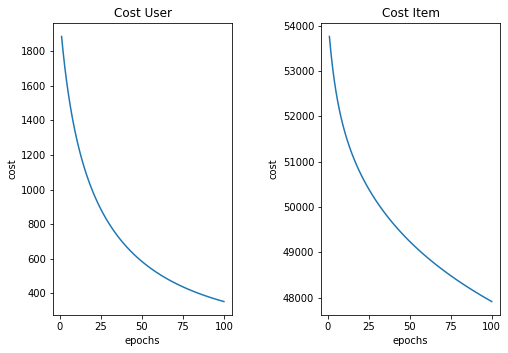

In [61]:
fig = plt.figure(figsize=(8,6))
ax_user = fig.add_subplot(121)
ax_user.set(title='Cost User', xlabel='epochs', ylabel = 'cost')
x = range(1, len(epoch_cost) + 1)
y = epoch_cost[:,0]
plt.plot(x,y)


ax_item = fig.add_subplot(122)
ax_item.set(title='Cost Item', xlabel='epochs', ylabel = 'cost')
x = range(1, len(epoch_cost) + 1)
y = epoch_cost[:,1]
plt.plot(x,y)

plt.subplots_adjust(top=0.8, wspace=0.5)
plt.show()

## 2. Make recommendations

In [62]:
k = 10 # recommend top k items/artists

<p> Select users for whom we make recommendations </p>

In [63]:
rec_users = pd.read_csv('recommendations.csv', header=0, usecols=[0])
rec_users

,userID
0,5
1,11
2,57
3,143
4,185
5,258
6,583
7,735
8,912
9,1004


<p> Next we calculate new scores over all the items for every selected user </p>

In [64]:
ind_users = pivoted.index.get_indexer(rec_users['userID'])
predictions = np.dot(X.reshape(-1,n), theta[ind_users].T.reshape(n,-1))

To every selected user we map the top k items/artists with the highest scores in a dictionary. <br> But before that we set **scores = 0** for all the items/artists the user is already consuming to so they won't appear in the top k again.

Finally we extract the recommendations from the dictionary to a dataframe...

In [65]:
rec_dict = {}
for i in range (len(ind_users)):
    items_used_by_user = pivoted.iloc[ind_users[i]].dropna().index
    ind_items = pivoted.columns.get_indexer(items_used_by_user)
    items_scored_by_user = predictions[:,i]
    items_scored_by_user [ind_items] = 0
    top_k = pd.Series(items_scored_by_user).nlargest(k).index.values.tolist()
    rec_dict[pivoted.index[ind_users[i]]] = pivoted.iloc[:, top_k].columns

recommendations = pd.DataFrame.from_dict(rec_dict, orient='index')

<p> ...and write them to the file </p>

In [66]:
recommendations.to_csv('recommendations.csv', index_label = 'userID', header=[ 'artistID_' + str(i + 1) for i in range (10)], index=True)